In [1]:
import pandas as pd
import numpy as np

# Train and test set splitting
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, GroupKFold, GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns



# Load Data

In [3]:
# Read source data
df4 = pd.read_csv(r"..\Data extraction and preprocessing\Model_4.csv")
location_lookup = pd.read_excel(r"..\Data extraction and preprocessing\Location Lookups.xlsx","Sheet1")

r, c = df4.shape
print(f"Source data has {r} rows and {c} columns")

# Keep Variety but ignore other non significant attributes
df_var_core = df4.filter(regex='Prod_13pcUM|Variety|crop_year|Location')
df_var_metrological = df4.filter(regex='^TMP|^AMT|^MinT|^MaxT')
df_var_soil = df4.filter(regex='^nitrogen|^soc|^bdod|^cec|^cfvo|^clay|^ocd|^phh2o|^sand|^silt')
df_var_remote = df4.filter(regex='NDVI|^EVI')

# Create test data combinations

# Metrological data (M)
df1 = pd.merge(df_var_core, df_var_metrological, left_index=True, right_index=True)
# Soil (S)
df2 = pd.merge(df_var_core, df_var_soil, left_index=True, right_index=True)
# Remote Sensing (R)
df3 = pd.merge(df_var_core, df_var_remote, left_index=True, right_index=True)
# Metrological, Soil, Remote Sensing (MSR)
df4 = pd.merge(df_var_core, df_var_metrological, left_index=True, right_index=True)
df4 = pd.merge(df4, df_var_soil, left_index=True, right_index=True)
df4 = pd.merge(df4, df_var_remote, left_index=True, right_index=True)
# Metrological, Remote Sensing (MR)
df5 = pd.merge(df_var_core, df_var_metrological, left_index=True, right_index=True)
df5 = pd.merge(df5, df_var_remote, left_index=True, right_index=True)
# Metrological, Soil (MS)
df6 = pd.merge(df_var_core, df_var_metrological, left_index=True, right_index=True)
df6 = pd.merge(df6, df_var_soil, left_index=True, right_index=True)
# Remote Sensing, Soil (RS)
df7 = pd.merge(df_var_core, df_var_remote, left_index=True, right_index=True)
df7 = pd.merge(df7, df_var_soil, left_index=True, right_index=True)

Source data has 778 rows and 115 columns


In [4]:
# Save copies of orginal data identifiers
df1_ids = df1[['Prod_13pcUM','crop_year','Location','Variety']].copy()
df2_ids = df2[['Prod_13pcUM','crop_year','Location','Variety']].copy()
df3_ids = df3[['Prod_13pcUM','crop_year','Location','Variety']].copy()
df4_ids = df4[['Prod_13pcUM','crop_year','Location','Variety']].copy()

# Explore source data

In [5]:
df1.shape

(778, 28)

## Wheat Varieties

                Location  crop_year  Unique Variety Count
0              AGUGLIANO       2012                    30
1              AGUGLIANO       2013                    30
2              AGUGLIANO       2014                    30
3               ARGELATO       2014                    30
4              CAMMARATA       2012                    30
5              CAMMARATA       2013                    30
6              CAMMARATA       2014                    30
7            FIORENZUOLA       2012                    30
8            FIORENZUOLA       2013                    30
9                 FOGGIA       2012                    30
10                FOGGIA       2013                    30
11                FOGGIA       2014                    30
12            LIBERTINIA       2012                    30
13            LIBERTINIA       2014                    30
14         MONTELIBRETTI       2012                    30
15         MONTELIBRETTI       2013                    30
16         MON

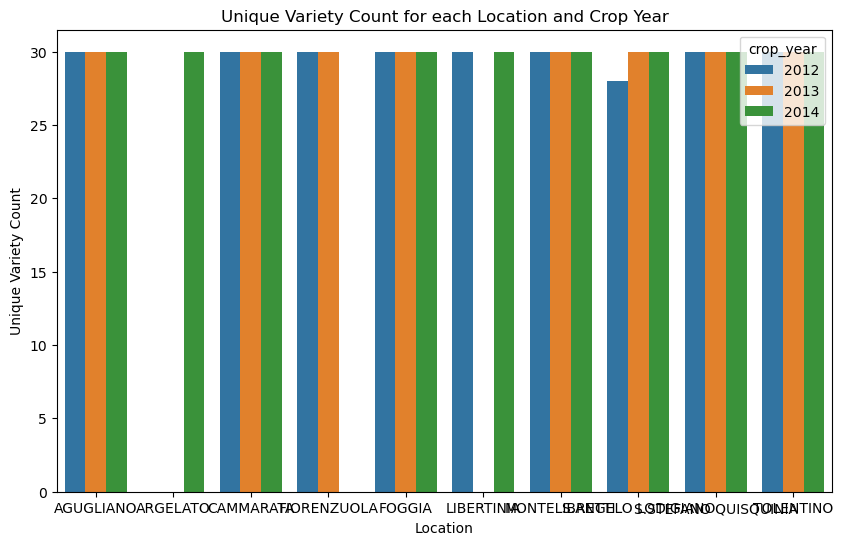

In [6]:
# Count unique Variety values for each Location and crop_year
unique_varieties = df1.groupby(['Location', 'crop_year'])['Variety'].nunique().reset_index()
unique_varieties.columns = ['Location', 'crop_year', 'Unique Variety Count']

# Display the table
print(unique_varieties)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Location', y='Unique Variety Count', hue='crop_year', data=unique_varieties)
plt.title("Unique Variety Count for each Location and Crop Year")
plt.show()

## Locations

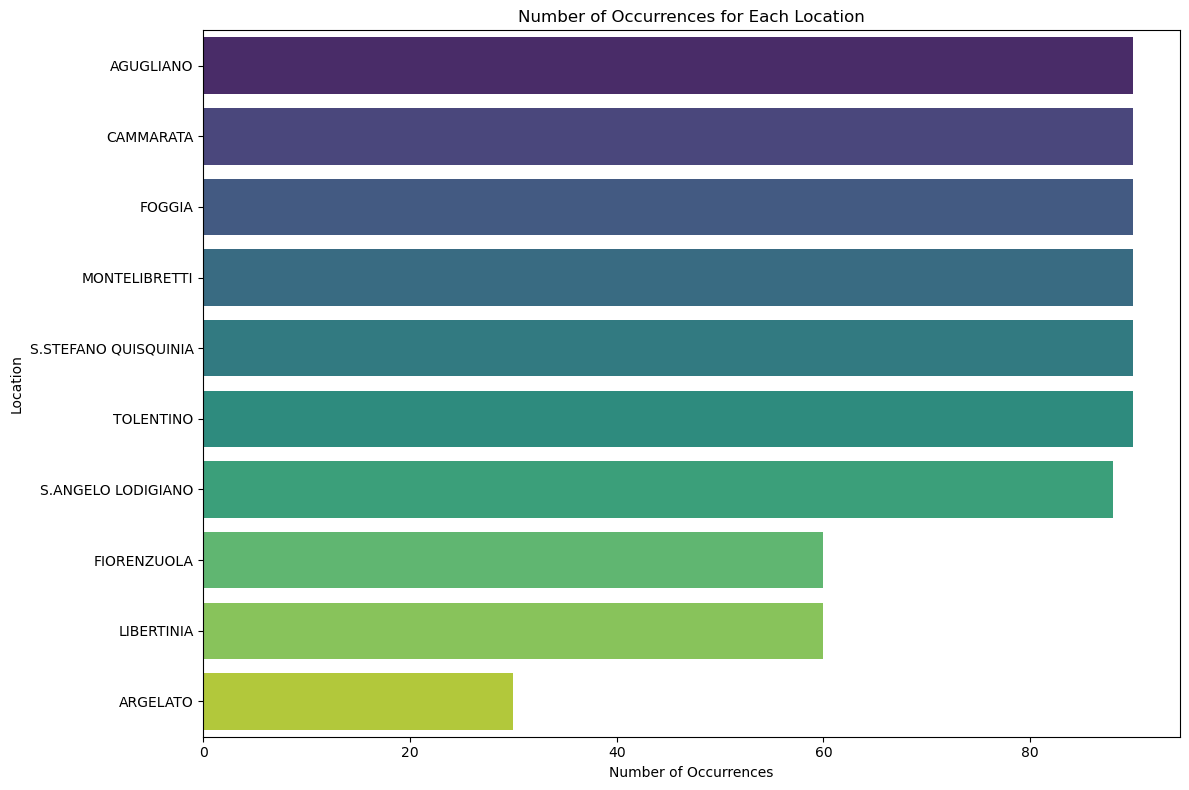

In [7]:
# Count occurrences of each Location
location_counts = df1['Location'].value_counts().reset_index()
location_counts.columns = ['Location', 'Count']

# Plot using horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Location', data=location_counts, palette='viridis')
plt.title("Number of Occurrences for Each Location")
plt.xlabel("Number of Occurrences")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

## Time (Years)

# Prepare Data

### Remove Outliers

In [8]:
# Create the function
def filter_within_3_std(df):
    mean_val = df['Prod_13pcUM'].mean()
    std_val = df['Prod_13pcUM'].std()
    lower_bound = mean_val - 3 * std_val
    upper_bound = mean_val + 3 * std_val
    
    return df[(df['Prod_13pcUM'] >= lower_bound) & (df['Prod_13pcUM'] <= upper_bound)]

# Apply function to each DataFrame and overwrite them
df1 = filter_within_3_std(df1)
df2 = filter_within_3_std(df2)
df3 = filter_within_3_std(df3)
df4 = filter_within_3_std(df4)
df5 = filter_within_3_std(df5)
df6 = filter_within_3_std(df6)
df7 = filter_within_3_std(df7)

## Remove low number of varieties 

In [9]:
def get_variety_counts(df):
    # Get value counts
    value_counts = df['Variety'].value_counts()

    # Convert the Series to a DataFrame
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = ['Variety', 'Count']

    print(f"Number of unique varieties: {value_counts_df.shape[0]}")
    
    return value_counts_df

counts_df1 = get_variety_counts(df1)

Number of unique varieties: 59


In [10]:
def filter_top_varieties(df, top_n=7):
    value_counts = df['Variety'].value_counts()
    to_keep = value_counts[value_counts >= 17].index[:top_n]
    return df[df['Variety'].isin(to_keep)]

# Use the function on your dataframes
df1 = filter_top_varieties(df1)
df2 = filter_top_varieties(df2)
df3 = filter_top_varieties(df3)
df4 = filter_top_varieties(df4)
df5 = filter_top_varieties(df5)
df6 = filter_top_varieties(df6)
df7 = filter_top_varieties(df7)

# Check number of varieties for df1 (just for verification)
counts_df1 = df1['Variety'].value_counts().reset_index().rename(columns={'index': 'Variety', 'Variety': 'Count'})

counts_df1.to_csv('top_variety_counts.csv', index=False)
counts_df1.head()

,Variety,Count
0,Anco Marzio,26
1,Kanakis,26
2,Odisseo,26
3,Ramirez,26
4,Saragolla,26


                Location  crop_year  Unique Variety Count
0              AGUGLIANO       2012                     7
1              AGUGLIANO       2013                     7
2              AGUGLIANO       2014                     7
3               ARGELATO       2014                     7
4              CAMMARATA       2012                     7
5              CAMMARATA       2013                     7
6              CAMMARATA       2014                     7
7            FIORENZUOLA       2012                     7
8            FIORENZUOLA       2013                     7
9                 FOGGIA       2012                     7
10                FOGGIA       2013                     7
11                FOGGIA       2014                     7
12            LIBERTINIA       2012                     7
13            LIBERTINIA       2014                     7
14         MONTELIBRETTI       2012                     7
15         MONTELIBRETTI       2013                     7
16         MON

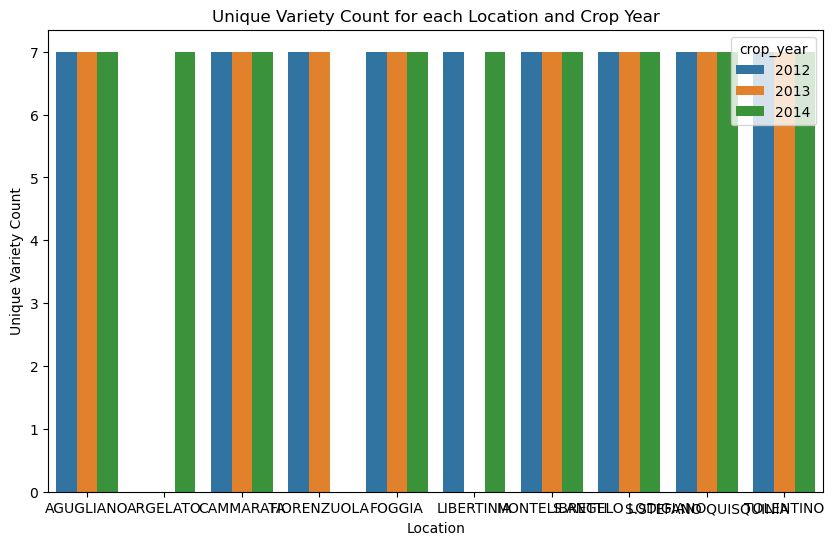

In [11]:
# Count unique Variety values for each Location and crop_year
unique_varieties = df1.groupby(['Location', 'crop_year'])['Variety'].nunique().reset_index()
unique_varieties.columns = ['Location', 'crop_year', 'Unique Variety Count']

# Display the table
print(unique_varieties)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Location', y='Unique Variety Count', hue='crop_year', data=unique_varieties)
plt.title("Unique Variety Count for each Location and Crop Year")
plt.show()

               Location  Unique Crop Year Count
0             AGUGLIANO                       3
1              ARGELATO                       1
2             CAMMARATA                       3
3           FIORENZUOLA                       2
4                FOGGIA                       3
5            LIBERTINIA                       2
6         MONTELIBRETTI                       3
7    S.ANGELO LODIGIANO                       3
8  S.STEFANO QUISQUINIA                       3
9             TOLENTINO                       3


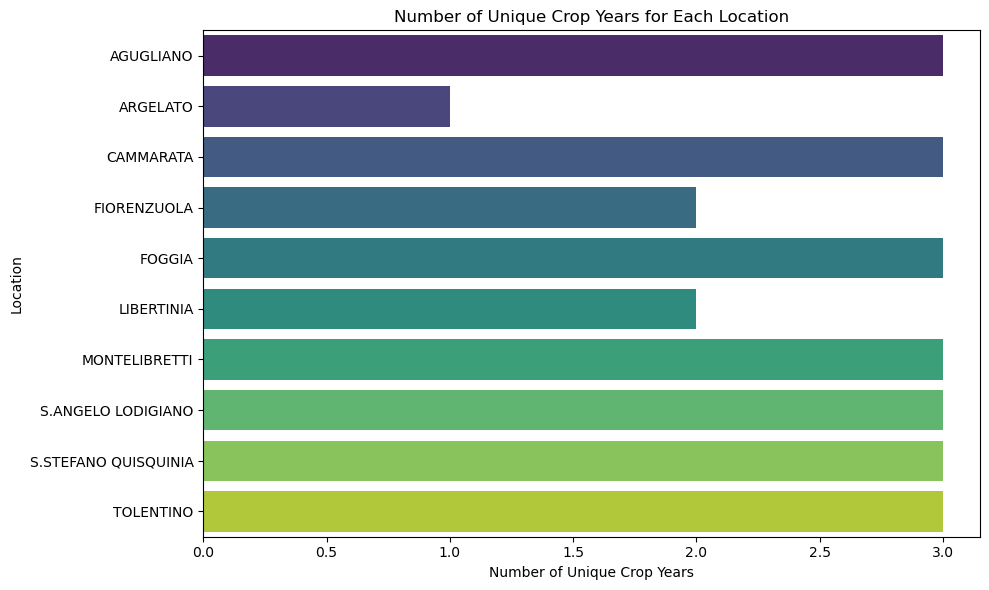

In [12]:
# Count unique crop years for each Location
unique_crop_years = df1.groupby('Location')['crop_year'].nunique().reset_index()
unique_crop_years.columns = ['Location', 'Unique Crop Year Count']

# Display the table
print(unique_crop_years)

# Plot using horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Unique Crop Year Count', y='Location', data=unique_crop_years, palette='viridis')
plt.title("Number of Unique Crop Years for Each Location")
plt.xlabel("Number of Unique Crop Years")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

# Analysis

#### Create groups for Group k-fold

In [13]:
def add_group_codes(*dfs):
    for df in dfs:
        df['group'] = df['Location'].astype(str) + '_' + df['crop_year'].astype(str)
        df['group_code'] = df['group'].astype('category').cat.codes
        df.drop('group', axis=1, inplace=True)  # Optional: drop the 'group' column
    if len(dfs) == 1:
        return dfs[0]  # return the single DataFrame, not as a tuple
    else:
        return dfs

df1 = add_group_codes(df1)

In [14]:
#GPM save with group_codes
df1_group_codes = df1[['group_code']].copy()


In [15]:
groups_training_info = df1[df1['crop_year'].isin([2012, 2013])]['group_code'].nunique()
print(f"Number of unique 'group_code' values for crop years 2012 and 2013 combined: {groups_training_info}")
groups_training = df1[df1['crop_year'].isin([2012, 2013])]['group_code']

groups_validation_info = df1[df1['crop_year'] == 2014]['group_code'].nunique()
print(f"Number of unique 'group_code' values for crop year 2014: {groups_validation_info}")

groups_training = groups_training.tolist()
df1 = df1.drop(columns=['group_code'])

Number of unique 'group_code' values for crop years 2012 and 2013 combined: 17
Number of unique 'group_code' values for crop year 2014: 9


#### Drop unnecessary variables

In [16]:
# Drop unessary columns from the dataframes
df1 = df1.drop(columns=['Location'])
df2 = df2.drop(columns=['Location'])
df3 = df3.drop(columns=['Location'])
df4 = df4.drop(columns=['Location'])
df5 = df5.drop(columns=['Location'])
df6 = df6.drop(columns=['Location'])
df7 = df7.drop(columns=['Location'])

In [17]:
def prepare_dataframes(dfs):
    train_dataframes = []
    test_dataframes = []

    for df in dfs:
        # Create training set
        train_df = df[(df['crop_year'] == 2012) | (df['crop_year'] == 2013)]
        test_df = df[df['crop_year'] == 2014]

        # Drop the crop_year column
        train_df = train_df.drop(columns=['crop_year'])
        test_df = test_df.drop(columns=['crop_year'])

        # Data used to predict y (independent variables)
        train_df = train_df.drop(columns=["Prod_13pcUM"])
        test_df = test_df.drop(columns=["Prod_13pcUM"])
        
        train_dataframes.append(train_df)
        test_dataframes.append(test_df)
        
    return train_dataframes, test_dataframes

# Call the function
dataframes = [df1, df2, df3, df4, df5, df6, df7]
X_trains, X_tests = prepare_dataframes(dataframes)

# If you need to access the variables individually:
X1_train, X2_train, X3_train, X4_train, X5_train, X6_train, X7_train = X_trains
X1_test, X2_test, X3_test, X4_test, X5_test, X6_test, X7_test = X_tests

# Create dependent variable for training set and testing set
# Retrieving y for training and test
y_train = df1[(df1['crop_year'] == 2012) | (df1['crop_year'] == 2013)][["Prod_13pcUM"]]
y_test = df1[df1['crop_year'] == 2014][["Prod_13pcUM"]]

# Print shape of 
print("y train: ", y_train.shape)
print("y test: ", y_train.shape)

print("x1 train: ", X1_train.shape)
print("x2 train: ", X2_train.shape)
print("x3 train: ", X3_train.shape)
print("x4 train: ", X4_train.shape)
print("x5 train: ", X5_train.shape)
print("x6 train: ", X6_train.shape)
print("x7 train: ", X7_train.shape)

print("x1 test: ", X1_test.shape)
print("x2 test: ", X2_test.shape)
print("x3 test: ", X3_test.shape)
print("x4 test: ", X4_test.shape)
print("x5 test: ", X5_test.shape)
print("x6 test: ", X6_test.shape)
print("x7 test: ", X7_test.shape)

y train:  (119, 1)
y test:  (119, 1)
x1 train:  (119, 25)
x2 train:  (119, 61)
x3 train:  (119, 25)
x4 train:  (119, 109)
x5 train:  (119, 49)
x6 train:  (119, 85)
x7 train:  (119, 85)
x1 test:  (63, 25)
x2 test:  (63, 61)
x3 test:  (63, 25)
x4 test:  (63, 109)
x5 test:  (63, 49)
x6 test:  (63, 85)
x7 test:  (63, 85)


### EDA

In [18]:
count_2012_2013 = len(df1[(df1['crop_year'] == 2012) | (df1['crop_year'] == 2013)])
print(count_2012_2013)

count_2014 = len(df1[(df1['crop_year'] == 2014)])
print(count_2014)

119
63


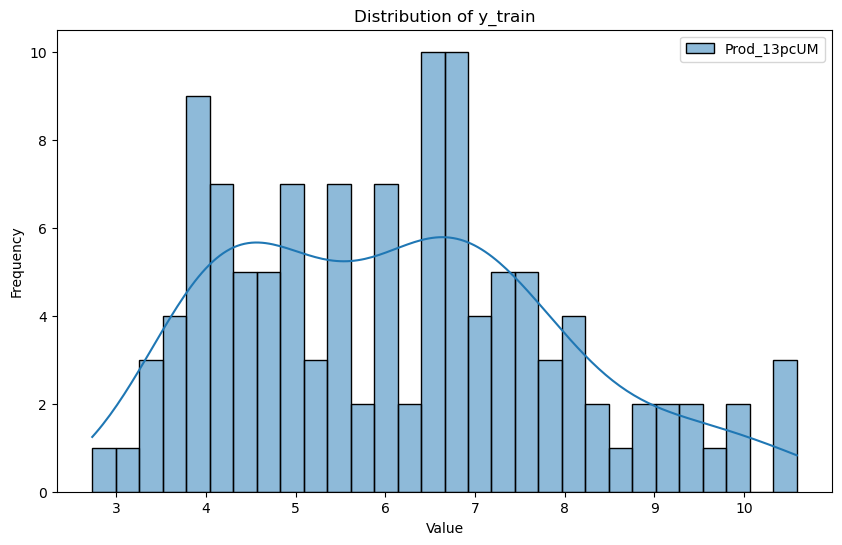

In [19]:
# Assuming y_train is a pandas Series or a dataframe column
plt.figure(figsize=(10, 6))

sns.histplot(y_train, kde=True, bins=30)

plt.title("Distribution of y_train")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [20]:
from scipy.stats import shapiro

y_train_series = y_train.iloc[:, 0]
skewness = y_train_series.skew()

if skewness > 0:
    print(f"The distribution is positively skewed with a skewness of {skewness:.2f}")
elif skewness < 0:
    print(f"The distribution is negatively skewed with a skewness of {skewness:.2f}")
else:
    print("The distribution is approximately symmetric.")
    
stat, p = shapiro(y_train)

alpha = 0.05
if p > alpha:
    print("The data appears to be normally distributed (fail to reject H0).")
else:
    print("The data does not appear to be normally distributed (reject H0).")

The distribution is positively skewed with a skewness of 0.43
The data does not appear to be normally distributed (reject H0).


## Setting up important functions for the different models

In [21]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler

def get_preprocessor(X, categorical_features=['Variety']):
    """
    Generate a preprocessor based on given DataFrame and categorical features.

    Parameters:
    - X: DataFrame with features.
    - categorical_features: List of categorical feature column names. Default is ['Variety'].

    Returns:
    - preprocessor: ColumnTransformer with necessary transformations.
    """
    # Derive numerical features from the dataframe
    numeric_features = list(set(X.columns) - set(categorical_features))

    # Create transformers for numerical and categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    return preprocessor

## Ridge Regression

In [22]:
# Set up dataframe to complile results 
rr_training_results = df1_ids.copy()
# Add in group_code attribute
rr_training_results = pd.merge(rr_training_results, df1_group_codes, left_index=True, right_index=True)
# drop any rows not in the test dataset
rr_training_results = rr_training_results[rr_training_results.index.isin(X1_train.index)]
# Add in location attributes
rr_training_results = pd.merge(rr_training_results, location_lookup, on=["Location"])


def RR_Train(X, y, groups, test_name, results_df, n_splits=4):

    preprocessor = get_preprocessor(X)

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selectkbest', SelectKBest(f_regression)),
                           ('clf', Ridge(random_state=42))])
    
    # Filter the k_values list
    k_values = [5, 10, 15, 20, 25, 30, 40] 
    k_values = [k for k in k_values if k <= X.shape[1]]

 
    params = {'clf__alpha': [1, 2, 3, 5, 10],
             'selectkbest__k': k_values}
    
    g_kf = GroupKFold(n_splits=n_splits)
    
    grid_pipe = GridSearchCV(pipe, 
                             params,
                             n_jobs=-1,
                             cv=g_kf,
                             scoring='neg_mean_squared_error')  
    
    grid_pipe.fit(X, y.values.ravel(), groups=groups)
    
    # Best hyperparameter after GridSearchCV
    best_hyperparameters = grid_pipe.best_params_
    best_estimator = grid_pipe.best_estimator_
    
    # Best average RMSE across all folds (negative because of 'neg_mean_squared_error' as scoring)
    avg_rmse = np.sqrt(-grid_pipe.best_score_)

    # Calculate MAE and R^2 using cross_val_predict for the best estimator
    y_pred = cross_val_predict(grid_pipe.best_estimator_, X, y.values.ravel(), cv=g_kf, groups=groups)
    avg_mae = mean_absolute_error(y, y_pred)
    avg_r2 = r2_score(y, y_pred)

    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return best_estimator, best_hyperparameters, avg_rmse, avg_mae, avg_r2, results_df

X1_best_estimator, X1_best_hyperparams, X1_avg_rmse, X1_avg_mae, X1_avg_r2, rr_training_results = RR_Train(X1_train, y_train, groups_training, "M", rr_training_results)
X2_best_estimator, X2_best_hyperparams, X2_avg_rmse, X2_avg_mae, X2_avg_r2, rr_training_results = RR_Train(X2_train, y_train, groups_training, "S", rr_training_results)
X3_best_estimator, X3_best_hyperparams, X3_avg_rmse, X3_avg_mae, X3_avg_r2, rr_training_results = RR_Train(X3_train, y_train, groups_training, "R", rr_training_results)
X4_best_estimator, X4_best_hyperparams, X4_avg_rmse, X4_avg_mae, X4_avg_r2, rr_training_results = RR_Train(X4_train, y_train, groups_training, "MSR", rr_training_results)
X5_best_estimator, X5_best_hyperparams, X5_avg_rmse, X5_avg_mae, X5_avg_r2, rr_training_results = RR_Train(X5_train, y_train, groups_training, "MR", rr_training_results)
X6_best_estimator, X6_best_hyperparams, X6_avg_rmse, X6_avg_mae, X6_avg_r2, rr_training_results = RR_Train(X6_train, y_train, groups_training, "MS", rr_training_results)
X7_best_estimator, X7_best_hyperparams, X7_avg_rmse, X7_avg_mae, X7_avg_r2, rr_training_results = RR_Train(X7_train, y_train, groups_training, "RS", rr_training_results)

# Create a dictionary for the results
data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["Ridge Regression"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "Average RMSE": [X1_avg_rmse, X2_avg_rmse, X3_avg_rmse, X4_avg_rmse, X5_avg_rmse, X6_avg_rmse, X7_avg_rmse],
    "Average MAE": [X1_avg_mae, X2_avg_mae, X3_avg_mae, X4_avg_mae, X5_avg_mae, X6_avg_mae, X7_avg_mae],
    "Average R^2": [X1_avg_r2, X2_avg_r2, X3_avg_r2, X4_avg_r2, X5_avg_r2, X6_avg_r2, X7_avg_r2]
}


# Convert the dictionary to a DataFrame
rr_train_results = pd.DataFrame(data)

In [23]:
# Set up dataframe to complile results 
rr_pred_results = df1_ids.copy()
# drop any rows not in the test dataset
rr_pred_results = rr_pred_results[rr_pred_results.index.isin(X1_test.index)]
# Add in location attributes
rr_pred_results = pd.merge(rr_pred_results, location_lookup, on=["Location"])

def RR_Test(X, y, best_estimator, test_name, results_df):
    
    # Predict and evaluate
    y_pred = best_estimator.predict(X)
    test_rmse = mean_squared_error(y, y_pred, squared=False)
    test_mae = mean_absolute_error(y, y_pred)
    test_r2 = r2_score(y, y_pred)
    #print(y_pred)

    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return test_rmse, test_mae, test_r2, results_df

X1_test_rmse, X1_test_mae, X1_test_r2, rr_pred_results = RR_Test(X1_test, y_test, X1_best_estimator, "M", rr_pred_results)
X2_test_rmse, X2_test_mae, X2_test_r2, rr_pred_results = RR_Test(X2_test, y_test, X2_best_estimator, "S", rr_pred_results)
X3_test_rmse, X3_test_mae, X3_test_r2, rr_pred_results = RR_Test(X3_test, y_test, X3_best_estimator, "R", rr_pred_results)
X4_test_rmse, X4_test_mae, X4_test_r2, rr_pred_results = RR_Test(X4_test, y_test, X4_best_estimator, "MSR", rr_pred_results)
X5_test_rmse, X5_test_mae, X5_test_r2, rr_pred_results = RR_Test(X5_test, y_test, X5_best_estimator, "MR", rr_pred_results)
X6_test_rmse, X6_test_mae, X6_test_r2, rr_pred_results = RR_Test(X6_test, y_test, X6_best_estimator, "MS", rr_pred_results)
X7_test_rmse, X7_test_mae, X7_test_r2, rr_pred_results = RR_Test(X7_test, y_test, X7_best_estimator, "RS", rr_pred_results)

# Create a dictionary for the results
data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["Ridge Regression"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "RMSE": [X1_test_rmse, X2_test_rmse, X3_test_rmse, X4_test_rmse, X5_test_rmse, X6_test_rmse, X7_test_rmse],
    "MAE": [X1_test_mae, X2_test_mae, X3_test_mae, X4_test_mae, X5_test_mae, X6_test_mae, X7_test_mae],
    "R^2": [X1_test_r2, X2_test_r2, X3_test_r2, X4_test_r2, X5_test_r2, X6_test_r2, X7_test_r2]
}

# Convert the dictionary to a DataFrame
rr_test_results = pd.DataFrame(data)

# Display the DataFrame
rr_test_results

# Create and display results
rr_results = pd.merge(rr_train_results, rr_test_results, on=['Experiment', 'Model'])
rr_results

,Experiment,Model,Best Hyperparameters_x,Average RMSE,Average MAE,Average R^2,Best Hyperparameters_y,RMSE,MAE,R^2
0,Meteorological,Ridge Regression,"{'clf__alpha': 10, 'selectkbest__k': 10}",1.968325,1.605644,-0.127464,"{'clf__alpha': 10, 'selectkbest__k': 10}",1.752913,1.312876,-0.058127
1,Soil,Ridge Regression,"{'clf__alpha': 10, 'selectkbest__k': 5}",2.010357,1.700660,-0.174315,"{'clf__alpha': 10, 'selectkbest__k': 5}",1.372862,1.155081,0.350961
2,Remote Sensing,Ridge Regression,"{'clf__alpha': 5, 'selectkbest__k': 25}",1.458988,1.229716,0.381173,"{'clf__alpha': 5, 'selectkbest__k': 25}",1.724735,1.327563,-0.024382
3,MSR,Ridge Regression,"{'clf__alpha': 10, 'selectkbest__k': 30}",1.784806,1.389804,0.078824,"{'clf__alpha': 10, 'selectkbest__k': 30}",1.570583,1.223018,0.150547
4,MR,Ridge Regression,"{'clf__alpha': 10, 'selectkbest__k': 40}",1.724768,1.354089,0.137523,"{'clf__alpha': 10, 'selectkbest__k': 40}",1.817450,1.333812,-0.137476
5,MS,Ridge Regression,"{'clf__alpha': 1, 'selectkbest__k': 25}",1.801748,1.383346,0.073386,"{'clf__alpha': 1, 'selectkbest__k': 25}",1.638334,1.377685,0.075680
6,RS,Ridge Regression,"{'clf__alpha': 1, 'selectkbest__k': 20}",1.825940,1.493095,0.024942,"{'clf__alpha': 1, 'selectkbest__k': 20}",2.390988,1.405938,-0.968666


## LASSO 

In [24]:
# Set up dataframe to complile results 
lr_training_results = df1_ids.copy()
# Add in group_code attribute
lr_training_results = pd.merge(lr_training_results, df1_group_codes, left_index=True, right_index=True)
# drop any rows not in the test dataset
lr_training_results = lr_training_results[lr_training_results.index.isin(X1_train.index)]
# Add in location attributes
lr_training_results = pd.merge(lr_training_results, location_lookup, on=["Location"])

def LR_Train(X, y, groups, test_name, results_df, n_splits=4):

    preprocessor = get_preprocessor(X)
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selectkbest', SelectKBest(f_regression)),
                           ('clf', Lasso(max_iter=10000, tol=0.01, random_state=42))]) 
    
    # Filter the k_values list
    k_values = [5, 10, 15, 20, 25, 30, 40] 
    k_values = [k for k in k_values if k <= X.shape[1]]

    params = {'clf__alpha': [0.001, 0.01, 0.1],
              'selectkbest__k': k_values}
    
    g_kf = GroupKFold(n_splits=n_splits)
    
    grid_pipe = GridSearchCV(pipe, 
                             params,
                             n_jobs=-1,
                             cv=g_kf,
                             scoring='neg_mean_squared_error')  
    
    grid_pipe.fit(X, y.values.ravel(), groups=groups)
    
    # Best hyperparameter after GridSearchCV
    best_hyperparameters = grid_pipe.best_params_
    best_estimator = grid_pipe.best_estimator_
    
    # Best average RMSE across all folds (negative because of 'neg_mean_squared_error' as scoring)
    avg_rmse = np.sqrt(-grid_pipe.best_score_)

    # Calculate MAE and R^2 using cross_val_predict for the best estimator
    y_pred = cross_val_predict(grid_pipe.best_estimator_, X, y.values.ravel(), cv=g_kf, groups=groups)
    avg_mae = mean_absolute_error(y, y_pred)
    avg_r2 = r2_score(y, y_pred)
    
    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return best_estimator, best_hyperparameters, avg_rmse, avg_mae, avg_r2, results_df

X1_best_estimator, X1_best_hyperparams, X1_avg_rmse, X1_avg_mae, X1_avg_r2, lr_training_results = LR_Train(X1_train, y_train, groups_training, "M", lr_training_results)
X2_best_estimator, X2_best_hyperparams, X2_avg_rmse, X2_avg_mae, X2_avg_r2, lr_training_results = LR_Train(X2_train, y_train, groups_training, "S", lr_training_results)
X3_best_estimator, X3_best_hyperparams, X3_avg_rmse, X3_avg_mae, X3_avg_r2, lr_training_results = LR_Train(X3_train, y_train, groups_training, "R", lr_training_results)
X4_best_estimator, X4_best_hyperparams, X4_avg_rmse, X4_avg_mae, X4_avg_r2, lr_training_results = LR_Train(X4_train, y_train, groups_training, "MSR", lr_training_results)
X5_best_estimator, X5_best_hyperparams, X5_avg_rmse, X5_avg_mae, X5_avg_r2, lr_training_results = LR_Train(X5_train, y_train, groups_training, "MR", lr_training_results)
X6_best_estimator, X6_best_hyperparams, X6_avg_rmse, X6_avg_mae, X6_avg_r2, lr_training_results = LR_Train(X6_train, y_train, groups_training, "MS", lr_training_results)
X7_best_estimator, X7_best_hyperparams, X7_avg_rmse, X7_avg_mae, X7_avg_r2, lr_training_results = LR_Train(X7_train, y_train, groups_training, "RS", lr_training_results)

# Create a dictionary for the results
data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["LASSO"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "Average RMSE": [X1_avg_rmse, X2_avg_rmse, X3_avg_rmse, X4_avg_rmse, X5_avg_rmse, X6_avg_rmse, X7_avg_rmse],
    "Average MAE": [X1_avg_mae, X2_avg_mae, X3_avg_mae, X4_avg_mae, X5_avg_mae, X6_avg_mae, X7_avg_mae],
    "Average R^2": [X1_avg_r2, X2_avg_r2, X3_avg_r2, X4_avg_r2, X5_avg_r2, X6_avg_r2, X7_avg_r2]
}

# Convert the dictionary to a DataFrame
lr_train_results = pd.DataFrame(data)

In [55]:
# Set up dataframe to complile results 
lr_pred_results = df1_ids.copy()
# drop any rows not in the test dataset
lr_pred_results = lr_pred_results[lr_pred_results.index.isin(X1_test.index)]
# Add in location attributes
lr_pred_results = pd.merge(lr_pred_results, location_lookup, on=["Location"])

def LR_Test(X, y, best_estimator, test_name, results_df):
    
    # Predict and evaluate
    y_pred = best_estimator.predict(X)
    test_rmse = mean_squared_error(y, y_pred, squared=False)
    test_mae = mean_absolute_error(y, y_pred)
    test_r2 = r2_score(y, y_pred)
    
    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()

    return test_rmse, test_mae, test_r2, results_df

X1_test_rmse, X1_test_mae, X1_test_r2, lr_pred_results = LR_Test(X1_test, y_test, X1_best_estimator, "M", lr_pred_results)
X2_test_rmse, X2_test_mae, X2_test_r2, lr_pred_results = LR_Test(X2_test, y_test, X2_best_estimator, "S", lr_pred_results)
X3_test_rmse, X3_test_mae, X3_test_r2, lr_pred_results = LR_Test(X3_test, y_test, X3_best_estimator, "R", lr_pred_results)
X4_test_rmse, X4_test_mae, X4_test_r2, lr_pred_results = LR_Test(X4_test, y_test, X4_best_estimator, "MSR", lr_pred_results)
X5_test_rmse, X5_test_mae, X5_test_r2, lr_pred_results = LR_Test(X5_test, y_test, X5_best_estimator, "MR", lr_pred_results)
X6_test_rmse, X6_test_mae, X6_test_r2, lr_pred_results = LR_Test(X6_test, y_test, X6_best_estimator, "MS", lr_pred_results)
X7_test_rmse, X7_test_mae, X7_test_r2, lr_pred_results = LR_Test(X7_test, y_test, X7_best_estimator, "RS", lr_pred_results)

# Create a dictionary for the results
data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["LASSO"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "RMSE": [X1_test_rmse, X2_test_rmse, X3_test_rmse, X4_test_rmse, X5_test_rmse, X6_test_rmse, X7_test_rmse],
    "MAE": [X1_test_mae, X2_test_mae, X3_test_mae, X4_test_mae, X5_test_mae, X6_test_mae, X7_test_mae],
    "R^2": [X1_test_r2, X2_test_r2, X3_test_r2, X4_test_r2, X5_test_r2, X6_test_r2, X7_test_r2]
}


# Convert the dictionary to a DataFrame
lr_test_results = pd.DataFrame(data)

# Display the DataFrame
lr_test_results

# Create and display results
lr_results = pd.merge(lr_train_results, lr_test_results, on=['Experiment', 'Model'])

lr_results

,Experiment,Model,Best Hyperparameters_x,Average RMSE,Average MAE,Average R^2,Best Hyperparameters_y,RMSE,MAE,R^2
0,Meteorological,LASSO,"{'clf__alpha': 0.1, 'selectkbest__k': 15}",2.064572,1.695163,-0.238022,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.339767,2.020484,-0.885222
1,Soil,LASSO,"{'clf__alpha': 0.1, 'selectkbest__k': 5}",2.083147,1.736691,-0.261084,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.440564,1.123753,0.285367
2,Remote Sensing,LASSO,"{'clf__alpha': 0.01, 'selectkbest__k': 10}",1.421587,1.172017,0.366173,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.823761,1.378467,-0.145389
3,MSR,LASSO,"{'clf__alpha': 0.1, 'selectkbest__k': 20}",1.844990,1.487802,0.013849,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.932170,1.623522,-0.285607
4,MR,LASSO,"{'clf__alpha': 0.001, 'selectkbest__k': 40}",1.824099,1.520453,0.017795,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",1.973901,1.675248,-0.341739
5,MS,LASSO,"{'clf__alpha': 0.01, 'selectkbest__k': 15}",1.694094,1.347200,0.172792,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.987422,1.725749,-0.360183
6,RS,LASSO,"{'clf__alpha': 0.1, 'selectkbest__k': 5}",1.943498,1.599762,-0.100210,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.954281,1.638293,-0.315198


## KNN

In [56]:
# Set up dataframe to complile results 
knn_training_results = df1_ids.copy()
# Add in group_code attribute
knn_training_results = pd.merge(knn_training_results, df1_group_codes, left_index=True, right_index=True)
# drop any rows not in the test dataset
knn_training_results = knn_training_results[knn_training_results.index.isin(X1_train.index)]
# Add in location attributes
knn_training_results = pd.merge(knn_training_results, location_lookup, on=["Location"])


def KNN_Train(X, y, groups, test_name, results_df, n_splits=4):

    preprocessor = get_preprocessor(X)
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selectkbest', SelectKBest(f_regression)),
                           ('clf', KNeighborsRegressor())])  

    # Filter the k_values list
    k_values = [5, 10, 15, 20, 25, 30, 40] 
    k_values = [k for k in k_values if k <= X.shape[1]]
    
    params = {'clf__n_neighbors': [3, 5, 7, 9, 11, 13],   
              'clf__weights': ['uniform', 'distance'],
              'selectkbest__k': k_values}
    
    g_kf = GroupKFold(n_splits=n_splits)
    
    grid_pipe = GridSearchCV(pipe, 
                             params,
                             n_jobs=-1,
                             cv=g_kf,
                             scoring='neg_mean_squared_error')  
    
    grid_pipe.fit(X, y.values.ravel(), groups=groups)
    
    # Best hyperparameter after GridSearchCV
    best_hyperparameters = grid_pipe.best_params_
    best_estimator = grid_pipe.best_estimator_
    
    # Best average RMSE across all folds (negative because of 'neg_mean_squared_error' as scoring)
    avg_rmse = np.sqrt(-grid_pipe.best_score_)

    # Calculate MAE and R^2 using cross_val_predict for the best estimator
    y_pred = cross_val_predict(grid_pipe.best_estimator_, X, y.values.ravel(), cv=g_kf, groups=groups)
    avg_mae = mean_absolute_error(y, y_pred)
    avg_r2 = r2_score(y, y_pred)
    
    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return best_estimator, best_hyperparameters, avg_rmse, avg_mae, avg_r2, results_df

X1_best_estimator, X1_best_hyperparams, X1_avg_rmse, X1_avg_mae, X1_avg_r2, knn_training_results = KNN_Train(X1_train, y_train, groups_training, "M", knn_training_results)
X2_best_estimator, X2_best_hyperparams, X2_avg_rmse, X2_avg_mae, X2_avg_r2, knn_training_results = KNN_Train(X2_train, y_train, groups_training, "S", knn_training_results)
X3_best_estimator, X3_best_hyperparams, X3_avg_rmse, X3_avg_mae, X3_avg_r2, knn_training_results = KNN_Train(X3_train, y_train, groups_training, "R", knn_training_results)
X4_best_estimator, X4_best_hyperparams, X4_avg_rmse, X4_avg_mae, X4_avg_r2, knn_training_results = KNN_Train(X4_train, y_train, groups_training, "MSR", knn_training_results)
X5_best_estimator, X5_best_hyperparams, X5_avg_rmse, X5_avg_mae, X5_avg_r2, knn_training_results = KNN_Train(X5_train, y_train, groups_training, "MR", knn_training_results)
X6_best_estimator, X6_best_hyperparams, X6_avg_rmse, X6_avg_mae, X6_avg_r2, knn_training_results = KNN_Train(X6_train, y_train, groups_training, "MS", knn_training_results)
X7_best_estimator, X7_best_hyperparams, X7_avg_rmse, X7_avg_mae, X7_avg_r2, knn_training_results = KNN_Train(X7_train, y_train, groups_training, "RS", knn_training_results)


data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["KNN"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "Average RMSE": [X1_avg_rmse, X2_avg_rmse, X3_avg_rmse, X4_avg_rmse, X5_avg_rmse, X6_avg_rmse, X7_avg_rmse],
    "Average MAE": [X1_avg_mae, X2_avg_mae, X3_avg_mae, X4_avg_mae, X5_avg_mae, X6_avg_mae, X7_avg_mae],
    "Average R^2": [X1_avg_r2, X2_avg_r2, X3_avg_r2, X4_avg_r2, X5_avg_r2, X6_avg_r2, X7_avg_r2]
}

# Convert the dictionary to a DataFrame
knn_train_results = pd.DataFrame(data)

In [57]:
# Set up dataframe to complile results 
knn_pred_results = df1_ids.copy()
# drop any rows not in the test dataset
knn_pred_results = knn_pred_results[knn_pred_results.index.isin(X1_test.index)]
# Add in location attributes
knn_pred_results = pd.merge(knn_pred_results, location_lookup, on=["Location"])

def KNN_Test(X, y, best_estimator, test_name, results_df):

    # Predict and evaluate
    y_pred = best_estimator.predict(X)
    test_rmse = mean_squared_error(y, y_pred, squared=False)
    test_mae = mean_absolute_error(y, y_pred)
    test_r2 = r2_score(y, y_pred)

    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return test_rmse, test_mae, test_r2, results_df

X1_test_rmse, X1_test_mae, X1_test_r2, knn_pred_results = KNN_Test(X1_test, y_test, X1_best_estimator, "M", knn_pred_results)
X2_test_rmse, X2_test_mae, X2_test_r2, knn_pred_results = KNN_Test(X2_test, y_test, X2_best_estimator, "S", knn_pred_results)
X3_test_rmse, X3_test_mae, X3_test_r2, knn_pred_results = KNN_Test(X3_test, y_test, X3_best_estimator, "R", knn_pred_results)
X4_test_rmse, X4_test_mae, X4_test_r2, knn_pred_results = KNN_Test(X4_test, y_test, X4_best_estimator, "MSR", knn_pred_results)
X5_test_rmse, X5_test_mae, X5_test_r2, knn_pred_results = KNN_Test(X5_test, y_test, X5_best_estimator, "MR", knn_pred_results)
X6_test_rmse, X6_test_mae, X6_test_r2, knn_pred_results = KNN_Test(X6_test, y_test, X6_best_estimator, "MS", knn_pred_results)
X7_test_rmse, X7_test_mae, X7_test_r2, knn_pred_results = KNN_Test(X7_test, y_test, X7_best_estimator, "RS", knn_pred_results)


data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["KNN"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "RMSE": [X1_test_rmse, X2_test_rmse, X3_test_rmse, X4_test_rmse, X5_test_rmse, X6_test_rmse, X7_test_rmse],
    "MAE": [X1_test_mae, X2_test_mae, X3_test_mae, X4_test_mae, X5_test_mae, X6_test_mae, X7_test_mae],
    "R^2": [X1_test_r2, X2_test_r2, X3_test_r2, X4_test_r2, X5_test_r2, X6_test_r2, X7_test_r2]
}

# Convert the dictionary to a DataFrame
knn_test_results = pd.DataFrame(data)

# Display the DataFrame
knn_test_results

# Create and display results
knn_results = pd.merge(knn_train_results, knn_test_results, on=['Experiment', 'Model'])
knn_results

,Experiment,Model,Best Hyperparameters_x,Average RMSE,Average MAE,Average R^2,Best Hyperparameters_y,RMSE,MAE,R^2
0,Meteorological,KNN,"{'clf__n_neighbors': 13, 'clf__weights': 'unif...",1.709536,1.401267,0.139709,"{'clf__n_neighbors': 13, 'clf__weights': 'unif...",1.740403,1.205653,-0.043079
1,Soil,KNN,"{'clf__n_neighbors': 13, 'clf__weights': 'unif...",2.337282,1.906005,-0.586508,"{'clf__n_neighbors': 13, 'clf__weights': 'unif...",1.513428,1.236801,0.211247
2,Remote Sensing,KNN,"{'clf__n_neighbors': 13, 'clf__weights': 'dist...",1.859599,1.580664,-0.005194,"{'clf__n_neighbors': 13, 'clf__weights': 'dist...",1.825598,1.358679,-0.147698
3,MSR,KNN,"{'clf__n_neighbors': 13, 'clf__weights': 'dist...",1.959880,1.548703,-0.114303,"{'clf__n_neighbors': 13, 'clf__weights': 'dist...",1.169908,0.921538,0.528674
4,MR,KNN,"{'clf__n_neighbors': 11, 'clf__weights': 'unif...",1.539458,1.278182,0.308802,"{'clf__n_neighbors': 11, 'clf__weights': 'unif...",1.791055,1.329553,-0.104677
5,MS,KNN,"{'clf__n_neighbors': 13, 'clf__weights': 'unif...",1.966899,1.517350,-0.113546,"{'clf__n_neighbors': 13, 'clf__weights': 'unif...",1.478807,1.191087,0.246921
6,RS,KNN,"{'clf__n_neighbors': 13, 'clf__weights': 'unif...",2.018809,1.673051,-0.187983,"{'clf__n_neighbors': 13, 'clf__weights': 'unif...",1.456736,1.194640,0.269232


## Decision Tree

In [58]:
# Set up dataframe to complile results 
dt_training_results = df1_ids.copy()
# Add in group_code attribute
dt_training_results = pd.merge(dt_training_results, df1_group_codes, left_index=True, right_index=True)
# drop any rows not in the test dataset
dt_training_results = dt_training_results[dt_training_results.index.isin(X1_train.index)]
# Add in location attributes
dt_training_results = pd.merge(dt_training_results, location_lookup, on=["Location"])

def DT_Train(X, y, groups, test_name, results_df, n_splits=4):

    preprocessor = get_preprocessor(X)

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selectkbest', SelectKBest(f_regression)),
                           ('clf', DecisionTreeRegressor(random_state=42))])

    # Filter the k_values list
    k_values = [5, 10, 15, 20, 25, 30, 40] 
    k_values = [k for k in k_values if k <= X.shape[1]]
    
    # Adjust these hyperparameters or add others as needed
    params = {
        'clf__max_depth': [3, 5, 7, 10],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'selectkbest__k': k_values
    }
    
    g_kf = GroupKFold(n_splits=n_splits)
    
    grid_pipe = GridSearchCV(pipe, 
                             params,
                             n_jobs=-1,
                             cv=g_kf,
                             scoring='neg_mean_squared_error')  
    
    grid_pipe.fit(X, y.values.ravel(), groups=groups)
    
    # Best hyperparameter after GridSearchCV
    best_hyperparameters = grid_pipe.best_params_
    best_estimator = grid_pipe.best_estimator_
    
    # Best average RMSE across all folds (negative because of 'neg_mean_squared_error' as scoring)
    avg_rmse = np.sqrt(-grid_pipe.best_score_)

    # Calculate MAE and R^2 using cross_val_predict for the best estimator
    y_pred = cross_val_predict(grid_pipe.best_estimator_, X, y.values.ravel(), cv=g_kf, groups=groups)
    avg_mae = mean_absolute_error(y, y_pred)
    avg_r2 = r2_score(y, y_pred)
    
    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return best_estimator, best_hyperparameters, avg_rmse, avg_mae, avg_r2, results_df

X1_best_estimator, X1_best_hyperparams, X1_avg_rmse, X1_avg_mae, X1_avg_r2, dt_training_results = DT_Train(X1_train, y_train, groups_training, "M", dt_training_results)
X2_best_estimator, X2_best_hyperparams, X2_avg_rmse, X2_avg_mae, X2_avg_r2, dt_training_results = DT_Train(X2_train, y_train, groups_training, "S", dt_training_results)
X3_best_estimator, X3_best_hyperparams, X3_avg_rmse, X3_avg_mae, X3_avg_r2, dt_training_results = DT_Train(X3_train, y_train, groups_training, "R", dt_training_results)
X4_best_estimator, X4_best_hyperparams, X4_avg_rmse, X4_avg_mae, X4_avg_r2, dt_training_results = DT_Train(X4_train, y_train, groups_training, "MSR", dt_training_results)
X5_best_estimator, X5_best_hyperparams, X5_avg_rmse, X5_avg_mae, X5_avg_r2, dt_training_results = DT_Train(X5_train, y_train, groups_training, "MR", dt_training_results)
X6_best_estimator, X6_best_hyperparams, X6_avg_rmse, X6_avg_mae, X6_avg_r2, dt_training_results = DT_Train(X6_train, y_train, groups_training, "MS", dt_training_results)
X7_best_estimator, X7_best_hyperparams, X7_avg_rmse, X7_avg_mae, X7_avg_r2, dt_training_results = DT_Train(X7_train, y_train, groups_training, "RS", dt_training_results)


data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["Decision Tree"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "Average RMSE": [X1_avg_rmse, X2_avg_rmse, X3_avg_rmse, X4_avg_rmse, X5_avg_rmse, X6_avg_rmse, X7_avg_rmse],
    "Average MAE": [X1_avg_mae, X2_avg_mae, X3_avg_mae, X4_avg_mae, X5_avg_mae, X6_avg_mae, X7_avg_mae],
    "Average R^2": [X1_avg_r2, X2_avg_r2, X3_avg_r2, X4_avg_r2, X5_avg_r2, X6_avg_r2, X7_avg_r2]
}

# Convert the dictionary to a DataFrame
dt_train_results = pd.DataFrame(data)

In [59]:
# Set up dataframe to complile results 
dt_pred_results = df1_ids.copy()
# drop any rows not in the test dataset
dt_pred_results = dt_pred_results[dt_pred_results.index.isin(X1_test.index)]
# Add in location attributes
dt_pred_results = pd.merge(dt_pred_results, location_lookup, on=["Location"])

def DT_Test(X, y, best_estimator, test_name, results_df):

    # Predict and evaluate
    y_pred = best_estimator.predict(X)
    test_rmse = mean_squared_error(y, y_pred, squared=False)
    test_mae = mean_absolute_error(y, y_pred)
    test_r2 = r2_score(y, y_pred)

    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return test_rmse, test_mae, test_r2, results_df

X1_test_rmse, X1_test_mae, X1_test_r2, dt_pred_results = DT_Test(X1_test, y_test, X1_best_estimator, "M", dt_pred_results)
X2_test_rmse, X2_test_mae, X2_test_r2, dt_pred_results = DT_Test(X2_test, y_test, X2_best_estimator, "S", dt_pred_results)
X3_test_rmse, X3_test_mae, X3_test_r2, dt_pred_results = DT_Test(X3_test, y_test, X3_best_estimator, "R", dt_pred_results)
X4_test_rmse, X4_test_mae, X4_test_r2, dt_pred_results = DT_Test(X4_test, y_test, X4_best_estimator, "MSR", dt_pred_results)
X5_test_rmse, X5_test_mae, X5_test_r2, dt_pred_results = DT_Test(X5_test, y_test, X5_best_estimator, "MR", dt_pred_results)
X6_test_rmse, X6_test_mae, X6_test_r2, dt_pred_results = DT_Test(X6_test, y_test, X6_best_estimator, "MS", dt_pred_results)
X7_test_rmse, X7_test_mae, X7_test_r2, dt_pred_results = DT_Test(X7_test, y_test, X7_best_estimator, "RS", dt_pred_results)

#data = {
#    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR"],
#    "Model": ["Decision Tree"]*5,
#    #"Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams],
#    "RMSE": [X1_test_rmse, X2_test_rmse, X3_test_rmse, X4_test_rmse, X5_test_rmse],
#    "MAE": [X1_test_mae, X2_test_mae, X3_test_mae, X4_test_mae, X5_test_mae],
#    "R^2": [X1_test_r2, X2_test_r2, X3_test_r2, X4_test_r2, X5_test_r2]
#}
data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["Decision Tree"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "RMSE": [X1_test_rmse, X2_test_rmse, X3_test_rmse, X4_test_rmse, X5_test_rmse, X6_test_rmse, X7_test_rmse],
    "MAE": [X1_test_mae, X2_test_mae, X3_test_mae, X4_test_mae, X5_test_mae, X6_test_mae, X7_test_mae],
    "R^2": [X1_test_r2, X2_test_r2, X3_test_r2, X4_test_r2, X5_test_r2, X6_test_r2, X7_test_r2]
}

# Convert the dictionary to a DataFrame
dt_test_results = pd.DataFrame(data)

# Display the DataFrame
dt_test_results

# Create and display results
dt_results = pd.merge(dt_train_results, dt_test_results, on=['Experiment', 'Model'])
dt_results

,Experiment,Model,Best Hyperparameters_x,Average RMSE,Average MAE,Average R^2,Best Hyperparameters_y,RMSE,MAE,R^2
0,Meteorological,Decision Tree,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",1.563888,1.242503,0.241777,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",2.751467,2.541905,-1.607030
1,Soil,Decision Tree,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.702964,2.281262,-1.114286,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.431277,1.132294,0.294553
2,Remote Sensing,Decision Tree,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.246556,1.790252,-0.508724,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.652005,2.101633,-1.421954
3,MSR,Decision Tree,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",2.339604,1.857689,-0.671133,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",2.001864,1.705283,-0.380023
4,MR,Decision Tree,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",1.740102,1.310768,0.060817,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",2.436800,2.112494,-1.044830
5,MS,Decision Tree,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.083715,1.695049,-0.274841,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.332232,1.886479,-0.873100
6,RS,Decision Tree,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.648495,2.323937,-1.056982,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.953668,1.624889,-0.314374


## Random Forest

In [60]:
# Set up dataframe to complile results 
rf_training_results = df1_ids.copy()
# Add in group_code attribute
rf_training_results = pd.merge(rf_training_results, df1_group_codes, left_index=True, right_index=True)
# drop any rows not in the test dataset
rf_training_results = rf_training_results[rf_training_results.index.isin(X1_train.index)]
# Add in location attributes
rf_training_results = pd.merge(rf_training_results, location_lookup, on=["Location"])

def RF_Train(X, y, groups, test_name, results_df, n_splits=4):

    preprocessor = get_preprocessor(X)

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selectkbest', SelectKBest(f_regression)),
                           ('clf', RandomForestRegressor(random_state=42))])
    
    # Filter the k_values list
    k_values = [5, 10, 15, 20, 25, 30, 40] 
    k_values = [k for k in k_values if k <= X.shape[1]]

    # Adjust these hyperparameters or add others as needed
    params = {
        'clf__n_estimators': [20, 50],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'selectkbest__k': k_values
    }
    
    g_kf = GroupKFold(n_splits=n_splits)
    
    grid_pipe = GridSearchCV(pipe, 
                             params,
                             n_jobs=-1,
                             cv=g_kf,
                             scoring='neg_mean_squared_error')  
    
    grid_pipe.fit(X, y.values.ravel(), groups=groups)
    
    # Best hyperparameter after GridSearchCV
    best_hyperparameters = grid_pipe.best_params_
    best_estimator = grid_pipe.best_estimator_
    
    # Best average RMSE across all folds (negative because of 'neg_mean_squared_error' as scoring)
    avg_rmse = np.sqrt(-grid_pipe.best_score_)

    # Calculate MAE and R^2 using cross_val_predict for the best estimator
    y_pred = cross_val_predict(grid_pipe.best_estimator_, X, y.values.ravel(), cv=g_kf, groups=groups)
    avg_mae = mean_absolute_error(y, y_pred)
    avg_r2 = r2_score(y, y_pred)
    
    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return best_estimator, best_hyperparameters, avg_rmse, avg_mae, avg_r2, results_df

X1_best_estimator, X1_best_hyperparams, X1_avg_rmse, X1_avg_mae, X1_avg_r2, rf_training_results = RF_Train(X1_train, y_train, groups_training, "M", rf_training_results)
X2_best_estimator, X2_best_hyperparams, X2_avg_rmse, X2_avg_mae, X2_avg_r2, rf_training_results = RF_Train(X2_train, y_train, groups_training, "S", rf_training_results)
X3_best_estimator, X3_best_hyperparams, X3_avg_rmse, X3_avg_mae, X3_avg_r2, rf_training_results = RF_Train(X3_train, y_train, groups_training, "R", rf_training_results)
X4_best_estimator, X4_best_hyperparams, X4_avg_rmse, X4_avg_mae, X4_avg_r2, rf_training_results = RF_Train(X4_train, y_train, groups_training, "MSR", rf_training_results)
X5_best_estimator, X5_best_hyperparams, X5_avg_rmse, X5_avg_mae, X5_avg_r2, rf_training_results = RF_Train(X5_train, y_train, groups_training, "MR", rf_training_results)
X6_best_estimator, X6_best_hyperparams, X6_avg_rmse, X6_avg_mae, X6_avg_r2, rf_training_results = RF_Train(X6_train, y_train, groups_training, "MS", rf_training_results)
X7_best_estimator, X7_best_hyperparams, X7_avg_rmse, X7_avg_mae, X7_avg_r2, rf_training_results = RF_Train(X7_train, y_train, groups_training, "RS", rf_training_results)


data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["Random Forest"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "Average RMSE": [X1_avg_rmse, X2_avg_rmse, X3_avg_rmse, X4_avg_rmse, X5_avg_rmse, X6_avg_rmse, X7_avg_rmse],
    "Average MAE": [X1_avg_mae, X2_avg_mae, X3_avg_mae, X4_avg_mae, X5_avg_mae, X6_avg_mae, X7_avg_mae],
    "Average R^2": [X1_avg_r2, X2_avg_r2, X3_avg_r2, X4_avg_r2, X5_avg_r2, X6_avg_r2, X7_avg_r2]
}

# Convert the dictionary to a DataFrame
rf_train_results = pd.DataFrame(data)

In [61]:
# Set up dataframe to complile results 
rf_pred_results = df1_ids.copy()
# drop any rows not in the test dataset
rf_pred_results = rf_pred_results[rf_pred_results.index.isin(X1_test.index)]
# Add in location attributes
rf_pred_results = pd.merge(rf_pred_results, location_lookup, on=["Location"])

def RF_Test(X, y, best_estimator, test_name, results_df):

    # Predict and evaluate
    y_pred = best_estimator.predict(X)
    test_rmse = mean_squared_error(y, y_pred, squared=False)
    test_mae = mean_absolute_error(y, y_pred)
    test_r2 = r2_score(y, y_pred)

    # Append predications to results dataframe
    results_df[test_name + '_pred'] = y_pred.tolist()
    
    return test_rmse, test_mae, test_r2, results_df

X1_test_rmse, X1_test_mae, X1_test_r2, rf_pred_results = RF_Test(X1_test, y_test, X1_best_estimator, "M", rf_pred_results)
X2_test_rmse, X2_test_mae, X2_test_r2, rf_pred_results = RF_Test(X2_test, y_test, X2_best_estimator, "S", rf_pred_results)
X3_test_rmse, X3_test_mae, X3_test_r2, rf_pred_results = RF_Test(X3_test, y_test, X3_best_estimator, "R", rf_pred_results)
X4_test_rmse, X4_test_mae, X4_test_r2, rf_pred_results = RF_Test(X4_test, y_test, X4_best_estimator, "MSR", rf_pred_results)
X5_test_rmse, X5_test_mae, X5_test_r2, rf_pred_results = RF_Test(X5_test, y_test, X5_best_estimator, "MR", rf_pred_results)
X6_test_rmse, X6_test_mae, X6_test_r2, rf_pred_results = RF_Test(X6_test, y_test, X6_best_estimator, "MS", rf_pred_results)
X7_test_rmse, X7_test_mae, X7_test_r2, rf_pred_results = RF_Test(X7_test, y_test, X7_best_estimator, "RS", rf_pred_results)


data = {
    "Experiment": ["Meteorological", "Soil", "Remote Sensing", "MSR", "MR", "MS", "RS"],
    "Model": ["Random Forest"]*7,
    "Best Hyperparameters": [X1_best_hyperparams, X2_best_hyperparams, X3_best_hyperparams, X4_best_hyperparams, X5_best_hyperparams, X6_best_hyperparams, X7_best_hyperparams],
    "RMSE": [X1_test_rmse, X2_test_rmse, X3_test_rmse, X4_test_rmse, X5_test_rmse, X6_test_rmse, X7_test_rmse],
    "MAE": [X1_test_mae, X2_test_mae, X3_test_mae, X4_test_mae, X5_test_mae, X6_test_mae, X7_test_mae],
    "R^2": [X1_test_r2, X2_test_r2, X3_test_r2, X4_test_r2, X5_test_r2, X6_test_r2, X7_test_r2]
}

# Convert the dictionary to a DataFrame
rf_test_results = pd.DataFrame(data)

# Display the DataFrame
rf_test_results

# Create and display results
rf_results = pd.merge(rf_train_results, rf_test_results, on=['Experiment', 'Model'])
rf_results

,Experiment,Model,Best Hyperparameters_x,Average RMSE,Average MAE,Average R^2,Best Hyperparameters_y,RMSE,MAE,R^2
0,Meteorological,Random Forest,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.556053,1.269786,0.280475,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.339767,2.020484,-0.885222
1,Soil,Random Forest,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.680892,2.270483,-1.083646,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.440564,1.123753,0.285367
2,Remote Sensing,Random Forest,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.135476,1.796479,-0.377826,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.823761,1.378467,-0.145389
3,MSR,Random Forest,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.102403,1.678123,-0.318770,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.932170,1.623522,-0.285607
4,MR,Random Forest,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",1.789109,1.461162,0.020146,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",1.973901,1.675248,-0.341739
5,MS,Random Forest,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.866710,1.434844,-0.027837,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.987422,1.725749,-0.360183
6,RS,Random Forest,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.304169,1.999423,-0.564867,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.954281,1.638293,-0.315198


In [62]:
# Concatenate the dataframes vertically
all_results = pd.concat([rf_results, dt_results, knn_results, lr_results, rr_results], ignore_index=True)
all_results

,Experiment,Model,Best Hyperparameters_x,Average RMSE,Average MAE,Average R^2,Best Hyperparameters_y,RMSE,MAE,R^2
0,Meteorological,Random Forest,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.556053,1.269786,0.280475,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.339767,2.020484,-0.885222
1,Soil,Random Forest,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.680892,2.270483,-1.083646,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.440564,1.123753,0.285367
2,Remote Sensing,Random Forest,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.135476,1.796479,-0.377826,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.823761,1.378467,-0.145389
3,MSR,Random Forest,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.102403,1.678123,-0.318770,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.932170,1.623522,-0.285607
4,MR,Random Forest,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",1.789109,1.461162,0.020146,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",1.973901,1.675248,-0.341739
5,MS,Random Forest,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.866710,1.434844,-0.027837,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",1.987422,1.725749,-0.360183
6,RS,Random Forest,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.304169,1.999423,-0.564867,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.954281,1.638293,-0.315198
7,Meteorological,Decision Tree,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",1.563888,1.242503,0.241777,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",2.751467,2.541905,-1.607030
8,Soil,Decision Tree,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",2.702964,2.281262,-1.114286,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",1.431277,1.132294,0.294553
9,Remote Sensing,Decision Tree,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.246556,1.790252,-0.508724,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",2.652005,2.101633,-1.421954


In [64]:
print("Best Experiments and Models based on Average RMSE:")
print(all_results.loc[all_results['Average RMSE'].idxmin(), ['Experiment', 'Model', 'Average RMSE']])

print("\nWorst Experiments and Models based on Average RMSE:")
print(all_results.loc[all_results['Average RMSE'].idxmax(), ['Experiment', 'Model', 'Average RMSE']])

print("\nBest Experiments and Models based on RMSE:")
print(all_results.loc[all_results['RMSE'].idxmin(), ['Experiment', 'Model', 'RMSE']])

print("\nWorst Experiments and Models based on RMSE:")
print(all_results.loc[all_results['RMSE'].idxmax(), ['Experiment', 'Model', 'RMSE']])


Best Experiments and Models based on Average RMSE:
Experiment      Remote Sensing
Model                    LASSO
Average RMSE          1.421587
Name: 23, dtype: object

Worst Experiments and Models based on Average RMSE:
Experiment               Soil
Model           Decision Tree
Average RMSE         2.702964
Name: 8, dtype: object

Best Experiments and Models based on RMSE:
Experiment         MSR
Model              KNN
RMSE          1.169908
Name: 17, dtype: object

Worst Experiments and Models based on RMSE:
Experiment    Meteorological
Model          Decision Tree
RMSE                2.751467
Name: 7, dtype: object


In [65]:
grouped_results = all_results.groupby(['Experiment', 'Model']).mean().reset_index()

C:\Users\AdamMorgan\AppData\Local\Temp\ipykernel_14036\1096156918.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_results = all_results.groupby(['Experiment', 'Model']).mean().reset_index()


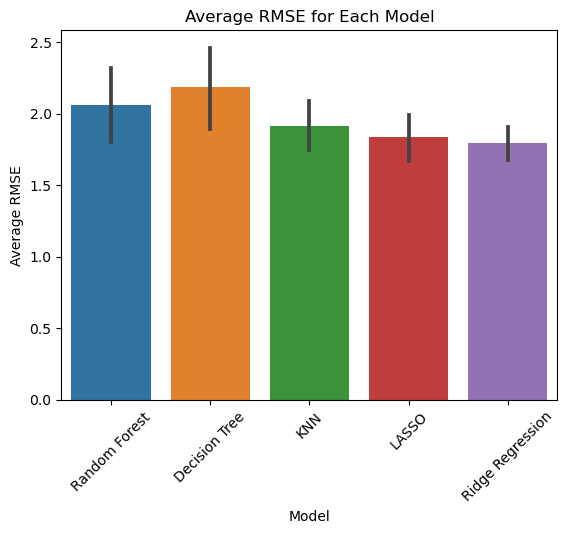

In [66]:

sns.barplot(data=all_results, x='Model', y='Average RMSE')
plt.title('Average RMSE for Each Model')
plt.xticks(rotation=45)
plt.show()

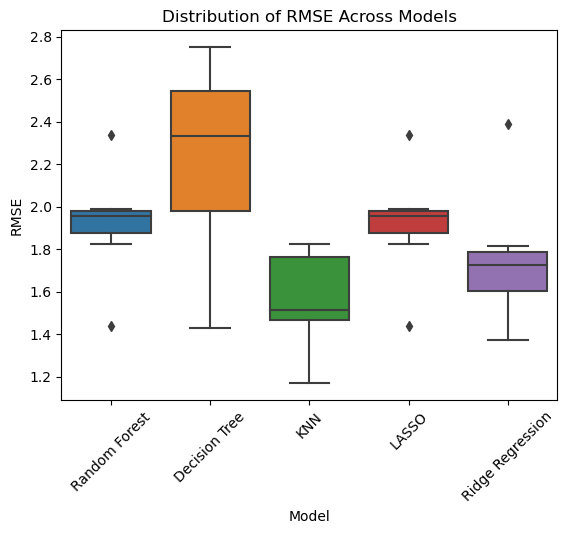

In [67]:
sns.boxplot(data=all_results, x='Model', y='RMSE')
plt.title('Distribution of RMSE Across Models')
plt.xticks(rotation=45)
plt.show()

# Group results to check models by Location, etc.

In [69]:
# Training Results
models = ['dt','knn','lr','rf','rr']
experiments = ['M','S','R','MSR','MR','MS','RS']
group_columns = ['Location','District_Name','Region','Variety']

# initialise dataframe to hold group test values
grouped_training_results = pd.DataFrame(columns=['model','experiment','group_name','group_value','group_size','rmse','mae','r2'])

for model in models:

    results_df_name = model + '_training_results'
    df = globals()[results_df_name]

    for group_col in group_columns:

        # retrieve grouped data from results
        grouped = df.groupby(group_col)

        for name, group in grouped:

            actual = group['Prod_13pcUM'].values
            group_size = actual.size

            for experiment in experiments:
                col_name = experiment + '_pred'
                pred = group[col_name].values

                test_rmse = mean_squared_error(actual, pred, squared=False)
                test_mae = mean_absolute_error(actual, pred)
                test_r2 = r2_score(actual, pred)

                grouped_training_results.loc[len(grouped_training_results)]=[model, experiment, group_col, name, group_size, test_rmse, test_mae, test_r2]

In [70]:
# Write training results data out to Excel
models = ['dt','knn','lr','rf','rr']


# create a excel writer object
with pd.ExcelWriter(r".\training_results.xlsx") as writer:

    for model in models:

        results_df_name = model + '_training_results'
        df = globals()[results_df_name]

        print("Writing " + results_df_name)

        df.to_excel(writer, sheet_name=model, index=False)

Writing dt_training_results
Writing knn_training_results
Writing lr_training_results
Writing rf_training_results
Writing rr_training_results


In [71]:
# Test/Prediction results
models = ['dt','knn','lr','rf','rr']
experiments = ['M','S','R','MSR','MR','MS','RS']
group_columns = ['Location','District_Name','Region','Variety']

# initialise dataframe to hold group test values
grouped_test_results = pd.DataFrame(columns=['model','experiment','group_name','group_value','group_size','rmse','mae','r2'])

for model in models:
    print(f"Model: {model}")

    results_df_name = model + '_pred_results'
    df = globals()[results_df_name]

    for group_col in group_columns:

        # retrieve grouped data from results
        grouped = df.groupby(group_col)

        for name, group in grouped:

            actual = group['Prod_13pcUM'].values
            group_size = actual.size

            for experiment in experiments:
                col_name = experiment + '_pred'
                pred = group[col_name].values

                test_rmse = mean_squared_error(actual, pred, squared=False)
                test_mae = mean_absolute_error(actual, pred)
                test_r2 = r2_score(actual, pred)

                grouped_test_results.loc[len(grouped_test_results)]=[model, experiment, group_col, name, group_size, test_rmse, test_mae, test_r2]



Model: dt
Model: knn
Model: lr
Model: rf
Model: rr


In [72]:
# Write test results data out to Excel
models = ['dt','knn','lr','rf','rr']


# create a excel writer object
with pd.ExcelWriter(r".\test_results.xlsx") as writer:

    for model in models:

        results_df_name = model + '_pred_results'
        df = globals()[results_df_name]

        print("Writing " + results_df_name)

        df.to_excel(writer, sheet_name=model, index=False)

Writing dt_pred_results
Writing knn_pred_results
Writing lr_pred_results
Writing rf_pred_results
Writing rr_pred_results


In [73]:
# Write training data out to Excel

# create a excel writer object
with pd.ExcelWriter(r".\results_group_training.xlsx") as writer:

    for model in models:

        grouped_training_results.to_excel(writer, sheet_name="Grouped Results", index=False)

In [74]:
# Write test data out to Excel

# create a excel writer object
with pd.ExcelWriter(r".\results_group_tests.xlsx") as writer:

    for model in models:

        grouped_test_results.to_excel(writer, sheet_name="Grouped Results", index=False)

In [75]:
all_results.to_csv(r".\MM SD 7 variety results.csv", index=False)